In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg
from typing import Tuple
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import dump, load
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import seaborn as sns

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import Callback

from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

In [2]:
# GPU 할당량 조정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)]) # 1660super 총 vram 6gb 중 5.5gb 할당
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: int, kernel_size: int, neg_slope: float = .01, dropout: float = .5,
                 name: str = ''):
        super(InnerConv1DBlock, self).__init__(name=name)
        self.conv1d = tf.keras.layers.Conv1D(h * filters, kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class Exp(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exp, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)


class Split(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Split, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, ::2], inputs[:, 1::2]

class Attention(tf.keras.layers.Layer):

    def __init__(self, units=64, shape = (1,1,1), **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units=shape[2], use_bias = False, name='attention_score_vec')
        self.lambda_ = tf.keras.layers.Lambda(lambda x : x[:,-1,:], output_shape=(shape[2],),name='last_hidden_state')
        # x.mean(axis = 1) - image attention, 
        self.dot1 = tf.keras.layers.Dot(axes=[1, 2], name='attention_score')
        self.activation = tf.keras.layers.Activation('softmax', name='attention_weight')
        self.dot2 =  tf.keras.layers.Dot(axes=[1, 1], name='context_vector')
        self.concat =  tf.keras.layers.Concatenate(name='attention_output')
        self.dense2 = tf.keras.layers.Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        self.attention_weight = []

    def call(self, inputs):

        hidden_states = inputs

        score_first_part = self.dense1(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.lambda_(hidden_states)
        score =self.dot1([h_t, score_first_part]) # batch, time_stamps
        self.attention_weight = score # batch , time_stamps
        attention_weights = self.activation(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.dot2([hidden_states, attention_weights]) # batch_size, n_features
        pre_activation = self.concat([context_vector, h_t])
        attention_vector =self.dense2(pre_activation)
        return attention_vector, context_vector

    def get_config(self):
        return {'Attention_weights': self.attention_weight}



class SciBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size: int, h: int):
        super(SciBlock, self).__init__()
        self.kernel_size = kernel_size
        self.h = h

        self.split = Split()
        self.exp = Exp()

    def build(self, input_shape):
        _, _, filters = input_shape

        self.psi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='psi')
        self.phi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='phi')
        self.eta = InnerConv1DBlock(filters, self.h, self.kernel_size, name='eta')
        self.rho = InnerConv1DBlock(filters, self.h, self.kernel_size, name='rho')

    def call(self, input_tensor):
        F_odd, F_even = self.split(input_tensor)

        F_s_odd = F_odd * self.exp(self.phi(F_even))
        F_s_even = F_even * self.exp(self.psi(F_s_odd))

        F_prime_odd = F_s_odd + self.rho(F_s_even)
        F_prime_even = F_s_even - self.eta(F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    def __init__(self):
        super(Interleave, self).__init__()

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2

        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1]*2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, output_length: int, level: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), shape : Tuple[float, float, float] = (0, 0, 0)):
        super(SciNet, self).__init__()
        self.level = level
        self.h = h
        self.kernel_size = kernel_size
        self.max_nodes = 2 ** (level + 1) - 1

        self.sciblocks = [SciBlock(kernel_size, h) for _ in range(self.max_nodes)]
        self.interleave = Interleave()
        self.Attention = Attention(shape=shape)
        self.flatten = tf.keras.layers.Flatten()
        # self.dense1 = tf.keras.layers.Dense(100, kernel_regularizer=L1L2(0.001, 0.01))
        self.dense = tf.keras.layers.Dense(output_length, kernel_regularizer=L1L2(0.001, 0.01))
        self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

    def build(self, input_shape):
        assert input_shape[1] / 2 ** 1 % 1 == 0  # inputs must be evenly divided at the lowest level of the tree
        [layer.build(input_shape) for layer in self.sciblocks]
    @tf.function
    def call(self, input_tensor):
        # cascade input down a binary tree of sci-blocks
        inputs = [input_tensor]
        for i in range(self.level):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            outputs = [out for j, tensor in zip(range(i_start, i_end), inputs) for out in self.sciblocks[j](tensor)]
            inputs = outputs

        x = self.interleave(outputs)
        x += input_tensor

        x, attention_weights = self.Attention(x)
        # x = self.dense1(x)
        x = self.dense(x)

        # x = self.regularizer(x)
        return x, attention_weights

    def get_config(self):
        return {'Attention_layer': self.Attention}

In [4]:
class VisualizeAttentionMap(Callback):
    
    def __init__(self, model, x, weights):

        super().__init__()
        self.model = model
        self.x = x
        self.weights = weights
        self.activation = tf.keras.layers.Activation('softmax')

    def on_epoch_begin(self, epoch, logs=None):
        #input_ = self.model._feed_inputs[0]
        #output = self.activation(input)
        #test = tf.keras.models.Model(inputs= input, outputs = output)
        #x = test(self.x)
        #attention_map = tf.matmul(self.weights,x).numpy()
        #test.layers[1].set_weights(weights = self.weights)
        #test.layers[1]  = test.layers[1].output.from_tensor(tensor =tf.nn.softmax(self.weights))
        #attention_map = test(self.x).numpy()
        attention_map = tf.nn.softmax(tf.math.divide(self.weights,3), axis = 1) # softmax smoothing
        
        #x = self.x[..., 0]
        if epoch % 10 == 0 :
            plt.figure(figsize= (10,5))
            maps = [attention_map]
            maps_names = ['attention layer']
            plt.imshow(maps[0], cmap='jet')
            plt.show()

        return attention_map


def softmax_with_temperature(z, T) : 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axi) 
    exp_z = np.exp(z-max_z) 
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

In [5]:
def split_sequence(sequence, look_back_window: int, forecast_horizon: int, stride: int = 1):
    X, y = [], []
    for i in range(0, len(sequence), stride):
        # find the end x and y
        end_ix = i + look_back_window
        end_iy = end_ix + forecast_horizon

        # check if there is enough elements to fill this x, y pair
        if end_iy > len(sequence):
            break

        X.append(sequence[i:end_ix])
        y.append(sequence[end_iy - 1 if forecast_horizon == 1 else end_ix:end_iy])
    return np.asarray(X), np.asarray(y)


class StocksImputer(TransformerMixin):
    def __init__(self, method: str = 'linear', fail_save: TransformerMixin = SimpleImputer()):
        self.method = method
        self.fail_save = fail_save

    def fit(self, data):
        if self.fail_save:
            self.fail_save.fit(data)
        return self

    def transform(self, data):
        # Interpolate missing values in columns
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        data = data.interpolate(method=self.method, limit_direction='both')
        # spline or time may be better?

        if self.fail_save:
            data = self.fail_save.transform(data)

        return data


def difference(dataset, interval=1, relative=False, min_price=1e-04):
    delta = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        if relative:
            prev_price = dataset[i - interval]
            prev_price[prev_price == 0] = min_price
            value /= prev_price
        delta.append(value)
    return np.asarray(delta)


class ARIMAPreprocessor(TransformerMixin):
    def __init__(self, y_col: str, look_back_window: int, forecast_horizon: int, stride: int, diff_order: int,
                 relative_diff: bool = True, splitXy: bool = True, scaling: str = 'minmax'):
        super().__init__()
        assert look_back_window > 0 and forecast_horizon > 0 and stride > 0

        self.y_col = y_col
        self.y_idx = None
        self.look_back_window = look_back_window
        self.forecast_horizon = forecast_horizon
        self.stride = stride
        self.diff_order = diff_order
        self.relative_diff = relative_diff
        self.splitXy = splitXy
        self.interpolation_imputer = StocksImputer(method='linear')

        if scaling == 'minmax':
            self.scaler = MinMaxScaler()
            self.y_scaler = MinMaxScaler()
        elif scaling == 'standard':
            self.scaler = StandardScaler()
            self.y_scaler = StandardScaler()
        elif scaling == 'robust':
            self.scaler = RobustScaler()
            self.y_scaler = RobustScaler()

    def fit_transform(self, data, **fit_params):
        self.y_idx = list(data.columns).index(self.y_col)

        # Fill missing values via interpolation
        data = self.interpolation_imputer.fit_transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        self.y_scaler.fit(data[:, self.y_idx].reshape(-1, 1))  # for reversing scaling post prediction
        data = self.scaler.fit_transform(data)

        if not self.splitXy:
            return data

        # Extract X, y from time series
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y, self.scaler

    def transform(self, data):
        # Fill missing values via interpolation
        data = self.interpolation_imputer.transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        data = self.scaler.transform(data)

        if not self.splitXy:
            return data

        # Extract X, y
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y

In [6]:
# Make model
def make_model(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def make_model_2(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    #tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
    #             metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [18]:
# Hyper Parametres
y_col = '일별배출량합계'
index_col = '일자'
cluster_num = 3

data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
data = data[data['읍면동'] == '알수없음']
data = data[['회당배출량', '일배출금액합계', '회당배출금액', '일배출횟수합계', '일별배출량합계']]

EPOCHS = 100

degree_of_differencing = 0
look_back_window, forecast_horizon = 60*2, 62 #전에 몇개의 데이터 참조, 후에 몇개 예측
batch_size = 64
learning_rate = 9e-5
h, kernel_size, level = 4, 5, 3
#stride = look_back_window + forecast_horizon  # unsure if any value lower than this would cause data leak

#data = data.sort_values(by = ['일자','읍면동'])
#data['일자'] = pd.to_datetime(data['일자'])
#data = data.set_index(keys = '일자')

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

In [19]:
train = data[:-look_back_window]
final_test_data = data[-look_back_window:]

In [21]:
train_data = train[:int(0.8 * (len(train) - (look_back_window + forecast_horizon)))]
val_data = train[int(0.8 * (len(train) - (look_back_window + forecast_horizon))):-look_back_window + forecast_horizon]
test_data = train[-(look_back_window + forecast_horizon):]

In [22]:
train_data.shape, val_data.shape, test_data.shape

((780, 5), (319, 5), (182, 5))

In [23]:
look_back_window + forecast_horizon

182

In [24]:
# Load and preprocess data
#data = data.set_index(keys = 'base_date')
#data = data.query('emd_nm == 24')

#train_data = data[:int(0.6 * len(data))]
#val_data = data[int(0.6 * len(data)):int(0.8 * len(data))]
#test_data = data[int(0.8 * len(data)):]

# Train model
preprocessor = ARIMAPreprocessor(y_col, look_back_window, forecast_horizon, 1, degree_of_differencing,
                                  relative_diff=True, scaling='standard')
X_train, y_train, scaler = preprocessor.fit_transform(train_data)
X_val, y_val = preprocessor.transform(val_data)
print(f'Input shape: X{X_train.shape}, y{y_train.shape}')

Input shape: X(599, 120, 5), y(599, 62)


In [25]:
model = make_model_2(batch_size, X_train.shape[1], X_train.shape[2])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 5)]          0         
_________________________________________________________________
sci_net (SciNet)             ((None, 62), (None, 5))   33395     
Total params: 33,395
Trainable params: 33,395
Non-trainable params: 0
_________________________________________________________________


In [26]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean()

val_loss = tf.keras.metrics.Mean()

train_loss_list = []
val_loss_list = []


def train_function(train_X, train_y):
    with tf.GradientTape() as tape:
     
        predictions, attention_weights = model(train_X)
       
        loss = loss_function(train_y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    mse = tf.keras.metrics.mse(train_y, predictions)
    mae = tf.keras.metrics.mae(train_y, predictions)

    return loss, mse, mae, attention_weights

def test_function(val_X, val_y):

    predictions, _ = model(val_X)
 
    loss = loss_function(val_y, predictions)

    val_loss(loss)
    mse = tf.keras.metrics.mse(val_y, predictions)
    mae = tf.keras.metrics.mae(val_y, predictions)

    return loss, mse, mae


In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [29]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

폴더가 이미 존재


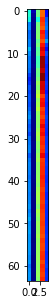

epochs: 1/100, train loss : 0.56573 train mse: 0.34749 train mae: 0.44583  validation loss: 4.60511 validation mse : 4.87381 validation mae: 1.71091
epochs: 2/100, train loss : 0.56366 train mse: 0.34698 train mae: 0.44542  validation loss: 4.60760 validation mse : 4.86651 validation mae: 1.70673
epochs: 3/100, train loss : 0.56158 train mse: 0.34242 train mae: 0.44236  validation loss: 4.60986 validation mse : 4.84737 validation mae: 1.70149
epochs: 4/100, train loss : 0.55952 train mse: 0.33972 train mae: 0.44050  validation loss: 4.61217 validation mse : 4.85727 validation mae: 1.70295
epochs: 5/100, train loss : 0.55747 train mse: 0.33679 train mae: 0.43849  validation loss: 4.61459 validation mse : 4.87280 validation mae: 1.70878
epochs: 6/100, train loss : 0.55543 train mse: 0.33380 train mae: 0.43645  validation loss: 4.61695 validation mse : 4.87213 validation mae: 1.70861
epochs: 7/100, train loss : 0.55341 train mse: 0.33138 train mae: 0.43461  validation loss: 4.61935 valida

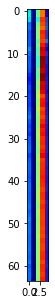

epochs: 11/100, train loss : 0.54547 train mse: 0.32341 train mae: 0.42867  validation loss: 4.62920 validation mse : 4.90389 validation mae: 1.71457
epochs: 12/100, train loss : 0.54352 train mse: 0.31955 train mae: 0.42608  validation loss: 4.63165 validation mse : 4.91122 validation mae: 1.71737
epochs: 13/100, train loss : 0.54158 train mse: 0.31681 train mae: 0.42428  validation loss: 4.63392 validation mse : 4.89511 validation mae: 1.71116
epochs: 14/100, train loss : 0.53964 train mse: 0.31424 train mae: 0.42257  validation loss: 4.63619 validation mse : 4.89935 validation mae: 1.71248
epochs: 15/100, train loss : 0.53773 train mse: 0.31223 train mae: 0.42094  validation loss: 4.63850 validation mse : 4.90842 validation mae: 1.71490
epochs: 16/100, train loss : 0.53582 train mse: 0.30925 train mae: 0.41902  validation loss: 4.64075 validation mse : 4.90652 validation mae: 1.71862
epochs: 17/100, train loss : 0.53392 train mse: 0.30707 train mae: 0.41746  validation loss: 4.64351

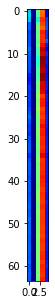

epochs: 21/100, train loss : 0.52652 train mse: 0.30047 train mae: 0.41183  validation loss: 4.65491 validation mse : 5.03267 validation mae: 1.76003
epochs: 22/100, train loss : 0.52470 train mse: 0.29826 train mae: 0.41039  validation loss: 4.65816 validation mse : 5.06104 validation mae: 1.76609
epochs: 23/100, train loss : 0.52290 train mse: 0.29587 train mae: 0.40897  validation loss: 4.66066 validation mse : 4.97293 validation mae: 1.73601
epochs: 24/100, train loss : 0.52110 train mse: 0.29416 train mae: 0.40759  validation loss: 4.66308 validation mse : 4.96801 validation mae: 1.73655
epochs: 25/100, train loss : 0.51933 train mse: 0.29259 train mae: 0.40643  validation loss: 4.66546 validation mse : 4.96695 validation mae: 1.74219
epochs: 26/100, train loss : 0.51757 train mse: 0.29162 train mae: 0.40540  validation loss: 4.66791 validation mse : 4.98248 validation mae: 1.74791
epochs: 27/100, train loss : 0.51583 train mse: 0.28927 train mae: 0.40384  validation loss: 4.67056

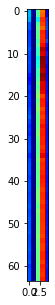

epochs: 31/100, train loss : 0.50899 train mse: 0.28274 train mae: 0.39947  validation loss: 4.68209 validation mse : 5.07787 validation mae: 1.77731
epochs: 32/100, train loss : 0.50731 train mse: 0.28087 train mae: 0.39836  validation loss: 4.68485 validation mse : 5.05426 validation mae: 1.76890
epochs: 33/100, train loss : 0.50565 train mse: 0.27932 train mae: 0.39717  validation loss: 4.68731 validation mse : 5.02062 validation mae: 1.75722
epochs: 34/100, train loss : 0.50399 train mse: 0.27780 train mae: 0.39606  validation loss: 4.68996 validation mse : 5.05010 validation mae: 1.76508
epochs: 35/100, train loss : 0.50235 train mse: 0.27654 train mae: 0.39505  validation loss: 4.69294 validation mse : 5.10086 validation mae: 1.77977
epochs: 36/100, train loss : 0.50072 train mse: 0.27493 train mae: 0.39409  validation loss: 4.69595 validation mse : 5.11172 validation mae: 1.78208
epochs: 37/100, train loss : 0.49911 train mse: 0.27428 train mae: 0.39332  validation loss: 4.69893

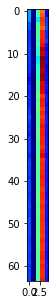

epochs: 41/100, train loss : 0.49279 train mse: 0.26841 train mae: 0.38850  validation loss: 4.71076 validation mse : 5.14032 validation mae: 1.79502
epochs: 42/100, train loss : 0.49124 train mse: 0.26706 train mae: 0.38762  validation loss: 4.71375 validation mse : 5.14447 validation mae: 1.79675
epochs: 43/100, train loss : 0.48970 train mse: 0.26556 train mae: 0.38676  validation loss: 4.71672 validation mse : 5.14765 validation mae: 1.79770
epochs: 44/100, train loss : 0.48818 train mse: 0.26402 train mae: 0.38552  validation loss: 4.71972 validation mse : 5.15700 validation mae: 1.80013
epochs: 45/100, train loss : 0.48666 train mse: 0.26283 train mae: 0.38459  validation loss: 4.72273 validation mse : 5.16566 validation mae: 1.80180
epochs: 46/100, train loss : 0.48516 train mse: 0.26197 train mae: 0.38391  validation loss: 4.72577 validation mse : 5.17588 validation mae: 1.80335
epochs: 47/100, train loss : 0.48368 train mse: 0.26181 train mae: 0.38334  validation loss: 4.72882

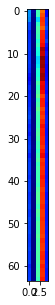

epochs: 51/100, train loss : 0.47788 train mse: 0.25615 train mae: 0.37961  validation loss: 4.74249 validation mse : 5.29119 validation mae: 1.83919
epochs: 52/100, train loss : 0.47646 train mse: 0.25549 train mae: 0.37935  validation loss: 4.74570 validation mse : 5.23927 validation mae: 1.82321
epochs: 53/100, train loss : 0.47504 train mse: 0.25513 train mae: 0.37845  validation loss: 4.74884 validation mse : 5.23538 validation mae: 1.82095
epochs: 54/100, train loss : 0.47364 train mse: 0.25340 train mae: 0.37691  validation loss: 4.75176 validation mse : 5.20701 validation mae: 1.81395
epochs: 55/100, train loss : 0.47224 train mse: 0.25171 train mae: 0.37621  validation loss: 4.75470 validation mse : 5.21715 validation mae: 1.81673
epochs: 56/100, train loss : 0.47085 train mse: 0.25084 train mae: 0.37549  validation loss: 4.75766 validation mse : 5.22475 validation mae: 1.81838
epochs: 57/100, train loss : 0.46948 train mse: 0.24982 train mae: 0.37441  validation loss: 4.76063

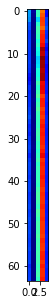

epochs: 61/100, train loss : 0.46409 train mse: 0.24708 train mae: 0.37164  validation loss: 4.77249 validation mse : 5.24336 validation mae: 1.82141
epochs: 62/100, train loss : 0.46278 train mse: 0.24709 train mae: 0.37160  validation loss: 4.77538 validation mse : 5.24950 validation mae: 1.82354
epochs: 63/100, train loss : 0.46148 train mse: 0.24511 train mae: 0.36980  validation loss: 4.77824 validation mse : 5.25032 validation mae: 1.82336
epochs: 64/100, train loss : 0.46018 train mse: 0.24373 train mae: 0.36949  validation loss: 4.78110 validation mse : 5.25520 validation mae: 1.82481
epochs: 65/100, train loss : 0.45889 train mse: 0.24292 train mae: 0.36888  validation loss: 4.78394 validation mse : 5.25908 validation mae: 1.82574
epochs: 66/100, train loss : 0.45761 train mse: 0.24211 train mae: 0.36795  validation loss: 4.78676 validation mse : 5.25966 validation mae: 1.82592
epochs: 67/100, train loss : 0.45635 train mse: 0.24136 train mae: 0.36738  validation loss: 4.78955

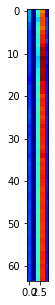

epochs: 71/100, train loss : 0.45140 train mse: 0.23879 train mae: 0.36493  validation loss: 4.80073 validation mse : 5.28318 validation mae: 1.83357
epochs: 72/100, train loss : 0.45019 train mse: 0.23831 train mae: 0.36491  validation loss: 4.80349 validation mse : 5.28386 validation mae: 1.83329
epochs: 73/100, train loss : 0.44899 train mse: 0.23787 train mae: 0.36406  validation loss: 4.80621 validation mse : 5.28171 validation mae: 1.83348
epochs: 74/100, train loss : 0.44780 train mse: 0.23769 train mae: 0.36393  validation loss: 4.80899 validation mse : 5.29732 validation mae: 1.84109
epochs: 75/100, train loss : 0.44662 train mse: 0.23701 train mae: 0.36279  validation loss: 4.81177 validation mse : 5.30499 validation mae: 1.84350
epochs: 76/100, train loss : 0.44545 train mse: 0.23654 train mae: 0.36267  validation loss: 4.81455 validation mse : 5.30891 validation mae: 1.84575
epochs: 77/100, train loss : 0.44429 train mse: 0.23541 train mae: 0.36156  validation loss: 4.81733

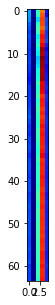

epochs: 81/100, train loss : 0.43972 train mse: 0.23243 train mae: 0.35954  validation loss: 4.82948 validation mse : 5.39472 validation mae: 1.88043
epochs: 82/100, train loss : 0.43860 train mse: 0.23235 train mae: 0.35921  validation loss: 4.83258 validation mse : 5.40366 validation mae: 1.88439
epochs: 83/100, train loss : 0.43750 train mse: 0.23343 train mae: 0.35950  validation loss: 4.83566 validation mse : 5.40574 validation mae: 1.88101
epochs: 84/100, train loss : 0.43641 train mse: 0.23152 train mae: 0.35790  validation loss: 4.83869 validation mse : 5.40211 validation mae: 1.87998
epochs: 85/100, train loss : 0.43531 train mse: 0.23023 train mae: 0.35782  validation loss: 4.84168 validation mse : 5.39999 validation mae: 1.87706
epochs: 86/100, train loss : 0.43423 train mse: 0.22965 train mae: 0.35726  validation loss: 4.84465 validation mse : 5.40300 validation mae: 1.87916
epochs: 87/100, train loss : 0.43316 train mse: 0.22952 train mae: 0.35670  validation loss: 4.84760

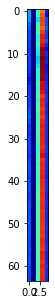

epochs: 91/100, train loss : 0.42898 train mse: 0.22817 train mae: 0.35491  validation loss: 4.85951 validation mse : 5.44071 validation mae: 1.89097
epochs: 92/100, train loss : 0.42795 train mse: 0.22714 train mae: 0.35502  validation loss: 4.86247 validation mse : 5.43771 validation mae: 1.89053
epochs: 93/100, train loss : 0.42693 train mse: 0.22640 train mae: 0.35436  validation loss: 4.86533 validation mse : 5.42258 validation mae: 1.89003
epochs: 94/100, train loss : 0.42591 train mse: 0.22569 train mae: 0.35352  validation loss: 4.86814 validation mse : 5.41950 validation mae: 1.89022
epochs: 95/100, train loss : 0.42490 train mse: 0.22519 train mae: 0.35299  validation loss: 4.87107 validation mse : 5.44649 validation mae: 1.89843
epochs: 96/100, train loss : 0.42390 train mse: 0.22501 train mae: 0.35284  validation loss: 4.87397 validation mse : 5.44931 validation mae: 1.90111
epochs: 97/100, train loss : 0.42291 train mse: 0.22592 train mae: 0.35309  validation loss: 4.87674

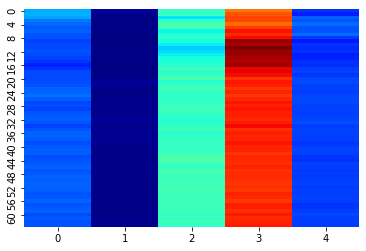

In [56]:
try :
    os.mkdir(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown')
except:
    print("폴더가 이미 존재")

visual_list = []
for epoch in range(EPOCHS):
    epoch_train_mse = 0
    epoch_train_mae = 0
    
    epoch_val_mse = 0
    epoch_val_mae = 0

    train_data_len = 0
    val_data_len = 0

    for train_X, train_y in train_dataset:
        _, train_mse, train_mae, attention_weights = train_function(train_X, train_y)
        train_data_len += 1
        epoch_train_mse += tf.reduce_mean(train_mse).numpy()
        epoch_train_mae += tf.reduce_mean(train_mae).numpy()
    for test_images, test_labels in val_dataset:
        _, val_mse, val_mae = test_function(test_images, test_labels)
        val_data_len += 1
        epoch_val_mse += tf.reduce_mean(val_mse).numpy()
        epoch_val_mae += tf.reduce_mean(val_mae).numpy()

    train_loss_list.append(train_loss.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    visual_result = VisualizeAttentionMap(model, train_X, attention_weights).on_epoch_begin(epoch)
    visual_list.append(visual_result.numpy())
    template = 'epochs: {}/{}, train loss : {:.5f} train mse: {:.5f} train mae: {:.5f}  validation loss: {:.5f} validation mse : {:.5f} validation mae: {:.5f}'
    print(template.format(epoch+1,
                         EPOCHS,
                         train_loss.result().numpy(),
                         epoch_train_mse / train_data_len,
                         epoch_train_mae / train_data_len,
                         val_loss.result().numpy(),
                         epoch_val_mse / val_data_len,
                         epoch_val_mae / val_data_len))
  
    if (epoch+1) % 10 == 0 :
        model.save_weights(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown/model_{epoch+1}.pth') 



try :
    os.mkdir(f'../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown')
except:
    print("폴더가 이미 존재")

for idx, img in enumerate(visual_list) :
    tmp = sns.heatmap(img, cmap ='jet', cbar = False)
    tmp.figure.savefig(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown/{idx}.png")
    
    
    
path = [f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown/{i}" for i in os.listdir(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown") if i.endswith(".png")]
paths = [np.array(Image.open(i)) for i in path]

try :
    os.mkdir(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown')
except :
    print("폴더가 이미 존재")
    
imageio.mimsave(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown/result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}_unknown.gif', paths, fps=5)

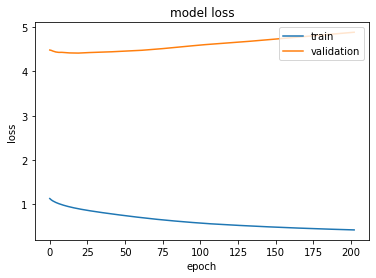

In [57]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [74]:
for i in range(10, 101 ,10) :
    model.load_weights(f"../data/model_weights/model_100_120_62_cluster_3_unknown/model_{i}.pth")
    X_test, y_test = preprocessor.transform(test_data.values)
    scores = np.mean(np.abs(y_test , model.predict(X_test)[0]))

    print(f"Model MAE : {scores}")

    # Predict
    y_pred,_ = model.predict(X_test)
    y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
    comparison = np.hstack([y_pred, y_test]) #0.93 #0.74 batch = 16 epoch = 100
    print(np.mean(np.abs(y_test - y_pred)))

Model MAE : 1.1779487133026123
844.7949336882563
Model MAE : 1.1779487133026123
746.372042748236
Model MAE : 1.1779487133026123
714.9621276855469
Model MAE : 1.1779487133026123
711.4947913385208
Model MAE : 1.1779487133026123
860.5696101034841
Model MAE : 1.1779487133026123
2476.382078601468
Model MAE : 1.1779487133026123
4909.515237623646
Model MAE : 1.1779487133026123
5629.313587803995
Model MAE : 1.1779487133026123
5776.9442502913935
Model MAE : 1.1779487133026123
5886.788387175529


In [75]:
model.load_weights("../data/model_weights/model_100_120_62_cluster_3_unknown/model_40.pth")
X_test, y_test = preprocessor.transform(test_data.values)
scores = np.mean(np.abs(y_test , model.predict(X_test)[0]))

print(f"Model MAE : {scores}")

# Predict
y_pred,_ = model.predict(X_test)
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
comparison = np.hstack([y_pred, y_test])
print(np.mean(np.abs(y_test - y_pred)))  # epcoh : 100, batch : 65 , before mae : 0.6359, after mae : 30468

Model MAE : 1.1779487133026123
711.4947913385208


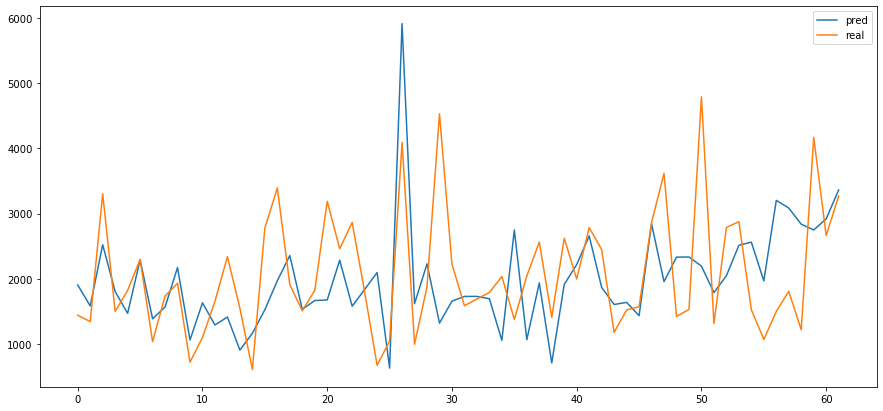

In [96]:
plt.figure(figsize=(15,7))
plt.plot(comparison)
plt.legend(['pred','real'])
plt.show()

In [70]:
data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
final_test_data = data[-look_back_window:]

In [76]:
final_test_data

,일자,월,요일,코로나발생여부,주말및공휴일여부,성수기여부,회당배출량,일배출금액합계,회당배출금액,일배출횟수합계,...,장외_근무평균,남_총거주,남_내거주,저녁_근무인구,여성_방문평균,저녁_장외_근무인구,남성_방문평균,점심_장외_근무인구,점심_근무인구,일별배출량합계
7542,2021-06-11,6,4,1,0,0,301193.131999,6910600.0,9003.268189,3824.0,...,3239.07480,28329,27178,23431.035500,225145.91480,654.935900,242869.28600,567.552200,24863.835600,206393.0
7543,2021-06-11,6,4,1,0,0,58066.481909,551600.0,1736.259557,250.0,...,521.99480,1770,1728,789.718300,30890.80140,81.030000,35537.87960,63.204200,921.844300,16490.0
7544,2021-06-11,6,4,1,0,0,8000.000000,96000.0,239.833333,12.0,...,1523.20655,8499,8210,5768.770846,138427.59365,128.397324,148601.99620,137.440178,7195.508063,2878.0
7545,2021-06-11,6,4,1,0,0,359162.575110,3033000.0,10743.934505,1248.0,...,2524.41830,19528,19062,12684.840100,245964.38590,385.082900,261666.11280,402.600000,17569.873100,90702.0
7546,2021-06-11,6,4,1,0,0,276179.452815,1980350.0,8259.197318,814.0,...,685.13470,13289,13010,8116.889900,121765.36590,140.883600,126398.97810,161.712200,11461.570700,59216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2021-06-30,6,2,1,0,0,51950.921215,597050.0,1554.027748,292.0,...,529.26770,1728,1687,661.321100,38523.04120,46.870900,40695.89140,122.573600,843.805400,17849.0
7658,2021-06-30,6,2,1,0,0,5603.333333,84050.0,167.800000,15.0,...,1188.81465,8525,8236,5952.102910,167482.92120,116.298459,181531.77955,122.421432,7295.254629,2517.0
7659,2021-06-30,6,2,1,0,0,330611.583180,3367800.0,9887.247688,1449.0,...,1848.36160,19639,19173,13497.829900,296442.80120,232.873900,322367.66770,287.497000,17820.560000,100714.0
7660,2021-06-30,6,2,1,0,0,270625.539646,2175450.0,8094.886784,981.0,...,760.44690,13306,13028,8691.385300,153869.57600,140.981300,166143.04570,152.460800,11667.667000,65043.0


In [84]:
final_test_data = final_test_data.set_index(['일자'])

In [87]:
final_test_data = final_test_data[['회당배출량', '일배출금액합계', '회당배출금액', '일배출횟수합계', '일별배출량합계']]

In [88]:
a = scaler.transform(final_test_data)

In [89]:
np.asarray([a]).shape

(1, 120, 5)

In [90]:
y_pred,_ = model.predict(np.asarray([a]))

In [91]:
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [97]:
final_test_data = data[-look_back_window:]

In [101]:
final_dong_list = []
final_dong_list.append('알수없음')

In [103]:
final_dong_cluster_3_unknown = list(final_dong_list) * int(y_pred.shape[0] / len(final_dong_list))

In [106]:
final_result = pd.DataFrame(np.vstack([final_dong_cluster_3_unknown, np.reshape(y_pred, (y_pred.shape[0]))]).T, columns=['읍면동','7_8월예측값'])

In [107]:
final_result

,읍면동,7_8월예측값
0,알수없음,-200.17227
1,알수없음,8990.851
2,알수없음,15443.472
3,알수없음,4827.9077
4,알수없음,16114.959
...,...,...
57,알수없음,11926.103
58,알수없음,8472.558
59,알수없음,13775.71
60,알수없음,9318.301


In [108]:
final_result.to_csv(f'../data/processed_data/cluster_{cluster_num}_unknown_final_result.csv', encoding = 'cp949', index = False)